In [2]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import random
import pprint

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import xray
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.sw.info

import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.sw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)




<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

# Individual g-points in solar infra-red bands

### Parameters used in solir()

      data xk/
     1  0.0010, 0.0133, 0.0422, 0.1334, 0.4217,
     2  1.334,  5.623,  31.62,  177.8,  1000.0   
     
  
      data hk/
     1 .20673,.08236,.01074,  .03497,.01157,.00360,
     2 .03011,.01133,.00411,  .02260,.01143,.00421,
     3 .01336,.01240,.00389,  .00696,.01258,.00326,
     4 .00441,.01381,.00499,  .00115,.00650,.00465,
     5 .00026,.00244,.00245,  .00000,.00094,.00145/

In [3]:
name_molecule = r'$H_{2}O$'

In [3]:
# Load CRD results

# CRD H2008
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/SW/examples/mls75_H2O/OUTPUT_CRD.dat'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)


In [4]:
# CRD H2012
pathout_crd = '../crd/SW/examples/mls75_H2O_solzen_60_H2012/OUTPUT_CRD.dat'
pnl_crd_H2012 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)

In [20]:
# Load CLIRAD results
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O_solir_gpts//OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, signed_fluxes = True)

In [358]:
# Load AER RRTMG's results
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples/mls_71lvls_H2O/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True)

In [4]:
def load_clirad_solirgpts(fpath, signed_fluxes = False, cooling_rate = False):
    '''
    Loads into an Xray Dataset the fluxes and heating rate output from CLIRAD-SW 
    for all solir spectral bands, all g-points, and all atmosphere layers.
    INPUT:
    fpath --- path of headered csv files where the columns are: 
              spectral band index
              g-point index
              atmosphere level index
              atmosphere pressure [mbar]
              upward flux [W / m2]
              downward flux [W / m2]
              net flux [W / m2]
              heating rate [deg / day]
    signed_fluxes --- False for all positive valued fluxes
                      True for downward fluxes to be negative and upward fluxes to be positive
    cooling_rate --- add a DataArray for cooling rate to the output Dataset
    OUTPUT:
    ds --- Xray Dataset,
           with dimensions:
               ib --- spectral band
               ik --- g-point
               pressure --- pressure at levels (interfaces)
               layer_pressure --- pressure at layers (levels)
           with data variables:
               flux_up --- upward flux
               flux_down --- downward flux
               net_flux --- net flux
               heating_rate --- heating rate
               [cooling_rate] --- cooling rate
    '''

    df = pd.read_csv(fpath, sep = r'\s+', skiprows = [0], header = None,
                    names = ['ib', 'ik', 'k', \
                             'pressure', 'flux_up', 'flux_down', 'net_flux', 'heating_rate'])
    
    df.drop(axis = 1, labels = ['k'], inplace = True) # drop level indices to avoid creating extra dimension
    df.set_index(['ib', 'ik', 'pressure'], inplace = True)
    
    ds = xray.Dataset.from_dataframe(df)
    
    layer_pressure_values = .5 * (ds.coords['pressure'][: -1].values + ds.coords['pressure'][1:].values)
    ds.coords['layer_pressure'] = layer_pressure_values
    
    da_heating_rates = ds['heating_rate'].sel(pressure = ds.coords['pressure'][1:])
    ds['heating_rate'] = (['ib', 'ik', 'layer_pressure'], da_heating_rates)
    
    if cooling_rate:
        ds['cooling_rate'] = - ds['heating_rate']
        
    if signed_fluxes:
        ds['flux_up'] *= -1
        ds['net_flux'] = ds['flux_up'] + ds['flux_down']
    
    return ds



def get_hrcr_gpoints(ds, ib = 6, iks = None, cooling_rate = False):
    if not iks:
        iks = range(1, 10 + 1)
    
    ratename = 'cooling_rate' if cooling_rate else 'heating_rate'
    
    hrcrs = [ds[ratename].sel(ib = ib, ik = ik).to_pandas() for ik in iks]
    
    return hrcrs



def matplotlib_nonnothing_markers(longname = False):
    '''
    Returns the list of plot markers available in matplotlib.
    Markers that are invisible are left out of this list.
    '''
    if longname:
        return [v for k, v in Line2D.markers.items() if v != 'nothing']
    else:
        return [k for k, v in Line2D.markers.items() if v != 'nothing']


    
def matplotlib_nonnothing_linestyles(longname = False):
    '''
    Returns the list of plot linestyles available in matplotlib.
    Linestyles that are invisible are left out of this list.
    '''
    if longname:
        return [v for k, v in Line2D.markers.items() if v != '_draw_nothing']
    else:
        return [k for k, v in Line2D.lineStyles.items() if v != '_draw_nothing']


    
def matplotlib_basic_colours():
    '''
    Returns a list of plot colours available in matplotlib.
    The colours in this list are easily distinguished from each
    other by eye.
    '''
    return ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    

    
def unique_colour_linestyle_products():
    '''
    Returns a list of unique tuples of plot colours and linestyles
    e.g. [('b', '-'), ('b', '-.'), ...]
    '''
    colours = matplotlib_basic_colours()
    linestyles = matplotlib_nonnothing_linestyles()
    
    uniques = list(itertools.product(colours, linestyles))
    return uniques



def unique_line_properties_products(linestyle = True,
                                    colour = True,
                                    marker = False):
    
    pass



def unique_colour_linestyle_marker_produces():
    '''
    Returns a list of unique tuples of plot colours, linestyles and markers.
    e.g. [('k', '-', 'x'), ('k', '-', 'o'), ...]
    '''
    colours = matplotlib_basic_colours()
    linestyles = matplotlib_nonnothing_linestyles()
    markers = matplotlib_nonnothing_markers()
    
    uniques = list(itertools.product(colours, linestyles, markers))
    return uniques
    

    
def unique_colour_linestyle_pairs(Npairs = 10):
    '''
    Returns a shuffled list of unique tuples of plot colours and linestyles
    of length Npairs.
    INPUT:
    Npairs --- length of list returned, 
               the number of unique tuples of plot colours and linestyles returned.
    '''
    uniques = unique_colour_linestyle_products()
    random.shuffle(uniques)
    return random.sample(uniques, Npairs)



def unique_colour_linestyle_marker_pairs(Npairs = 10):
    uniques = unique_colour_linestyle_marker_products()
    random.shuffle(uniques)
    return random.sample(uniques, Npairs)



def plot_pdseries_indexVSvalues_linearlog(srss = None, 
                                          names = None, 
                                          colours = None, linestyles = None, markers = None,
                                          ylim = None,
                                          xlim_linear = None, xlim_log = None,
                                          title = None, ylabel = None, xlabel = None,
                                          figsize = (8, 5)):
    '''
    Plots index versus values for one or more Pandas.Series, 
    for both linear and log y-scales.  
    
    When y-scale is linear, x-axis limits are the minimum and maximum
    values for the range of y above 1.  When y-scale log, x-axis limits
    are the minumum and maximum values for the range of y below 1.  
    '''
    
    xys = list(itertools.chain(*[(srs.values, srs.index.values) \
                                 for srs in srss]))
    
    
    if not markers:
        markers = [None for _ in range(len(xys))]
        
    if not linestyles:
        linestyles = ['None' for _ in range(len(xys))]
        
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2,
                           figsize = figsize)
    
    for yscale, ax in zip(('linear', 'log'), axs):

        lines = ax.plot(*xys)
        
        [plt.setp(line, \
                  linestyle = style, color = colour, marker = marker,\
                  linewidth = 2.)\
         for line, style, colour, marker in zip(lines, linestyles, colours, markers)]
        
        ax.set_title(title)
        ax.grid(b = True)
        ax.legend(names, loc = 'best')
        
        if ylim:
            ax.set_ylim(ylim)
        ax.set_yscale(yscale)
        ax.invert_yaxis()
        ax.set_ylabel(ylabel)
        
        if yscale == 'linear':            
            if xlim_linear:
                ax.set_xlim(xlim_linear)
            else:
                if ylim:
                    ymin, ymax = ylim
                    xmin = min([srs[(srs.index > 1e0) & (srs.index < ymax)].min() for srs in srss])
                    xmax = max([srs[(srs.index > 1e0) & (srs.index < ymin)].max() for srs in srss])
                else:
                    xmin = min([srs[srs.index > 1e0].min() for srs in srss])
                    xmax = max([srs[srs.index > 1e0].max() for srs in srss])

                dx = xmax - xmin
                xmin -= .1 * dx
                xmax += .1 * dx
                ax.set_xlim((xmin, xmax))
        elif yscale == 'log':
            if xlim_log:
                ax.set_xlim(xlim_log)
            else:
                if ylim:
                    ymin, ymax = ylim 
                    xmin = min([srs[(srs.index < 1e0) & (srs.index > ymin)].min() for srs in srss])
                    xmax = max([srs[(srs.index < 1e0) & (srs.index > ymin)].max() for srs in srss])
                else:
                    xmin = min([srs[srs.index < 1e0].min() for srs in srss])
                    xmax = max([srs[srs.index < 1e0].max() for srs in srss])
  
                dx = xmax - xmin
                xmin -= .1 * dx
                xmax += .1 * dx
                ax.set_xlim((xmin, xmax))                    
                
        ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
        ax.set_xlabel(xlabel)
    return fig
        
        
    

    
def plot_pressure_VS_dTdt_linearlog(ds, whichrate = 'heating_rate', ib = 7):
    
    Nik = 10
    
    srss = [ds[whichrate].sel(ib = ib, ik = ik).to_pandas() for ik in range(1, Nik + 1)]
    names = ['(ib, ik) = ({}, {})'.format(ib, ik) for ik in range(1, Nik + 1)]
        
    colours, linestyles = zip(*unique_colour_linestyle_pairs(Npairs = Nik))
    
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(whichrate)
    title = 'Band {}'.format(ib)
    figsize = (15, 10)
    
    fig = plot_pdseries_indexVSvalues_linearlog(srss = srss,\
                                                names = names,
                                                colours = colours,
                                                linestyles = linestyles,
                                                ylabel = ylabel,
                                                xlabel = xlabel,
                                                figsize = figsize,
                                                title = title)
    return fig
    


In [5]:
def hr_from_pnl_clirad(pnl_clirad, ib = 6):
    '''
    This plots to compare the heating rates from OUTPUT_CLIRAD and solir_gpts
    in shorwave bands 6, 7 and 8 (the solir bands).
    '''
    df = cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl_clirad, wbands = [ib])
    hr = df['heating_rate'][1:]
    
    layer_pressure = .5 * (df['pressure'][: -1].values + df['pressure'][1:].values)
    hr.index = layer_pressure
    return hr




def compare_OUTPUT_CLIRAD_and_solir_gpts(pnl, ds, ib = 6):
    '''
    This plots to compare the heating rates from OUTPUT_CLIRAD and solir_gpts
    in shorwave bands 6, 7 and 8 (the solir bands).
    INPUT:
    pnl --- Pandas Panel from loading OUTPUT_CLIRAD
    ds  --- Xray Dataset from loading solir_gpts
    ib  --- spectral band to compare (6, 7, or 8)
    '''
    Trate = 'heating_rate'
    
    srs_output_clirad = hr_from_pnl_clirad(pnl_clirad, ib = ib)
    srs_solir_gpts = ds[Trate].sel(ib = ib).sum(dim = 'ik').to_pandas()
    
    srss = [srs_solir_gpts, srs_output_clirad]
    names = ['summed outside CLIRAD', 'summed inside CLIRAD']
    colours, linestyles = zip(*unique_colour_linestyle_pairs(Npairs=2))
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(Trate)
    title = 'Band {}'.format(ib)
    
    fig = plot_pdseries_indexVSvalues_linearlog(srss = srss,
                                                names = names,
                                                linestyles = linestyles,
                                                colours = colours,
                                                ylabel = ylabel, xlabel = xlabel, title = title,
                                                figsize = (15, 10))
    return fig

In [20]:
# load output data from OUTPUT_CLIRAD_solir_gpoints.dat

pathout_clirad_solir_gpts = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O_solir_gpts/OUTPUT_CLIRAD_solir_gpoints.dat'
ds = load_clirad_solirgpts(pathout_clirad_solir_gpts)



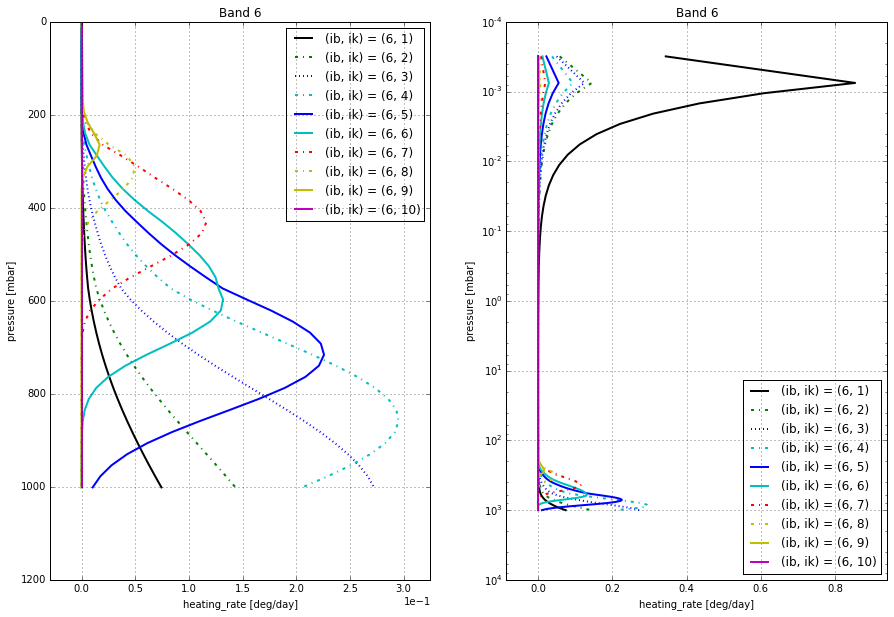

In [21]:
# Heating rate for all g-points.  Band 6

ib = 6
whichrate = 'heating_rate'

fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate = whichrate, ib = ib)

In [22]:
# Total heating rate of Band 6

#fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib = 6)

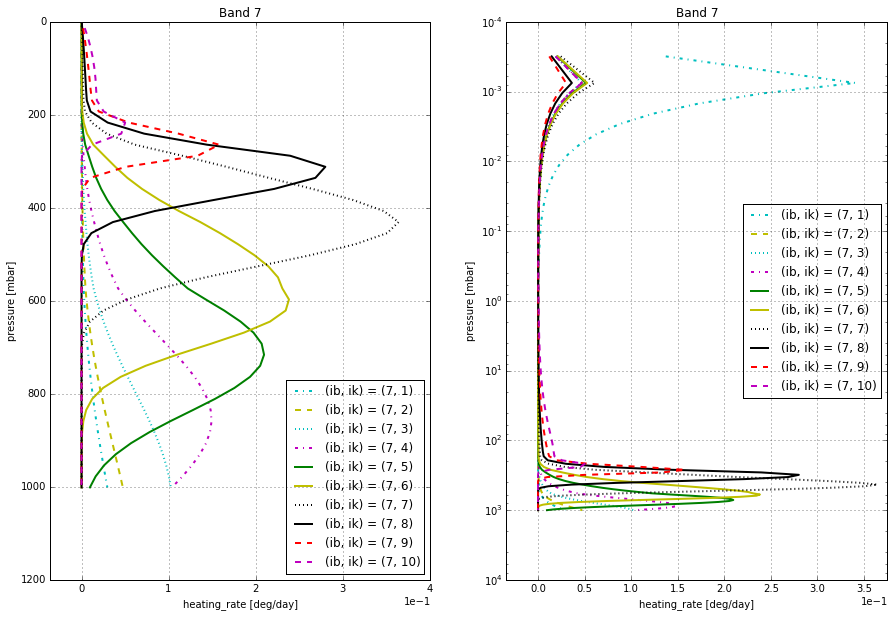

In [23]:
# Heating rate for all g-points.  Band 7

ib = 7
whichrate = 'heating_rate'

fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate = whichrate, ib = ib)

In [24]:
# Total heating rate of Band 7

#fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib = 7)

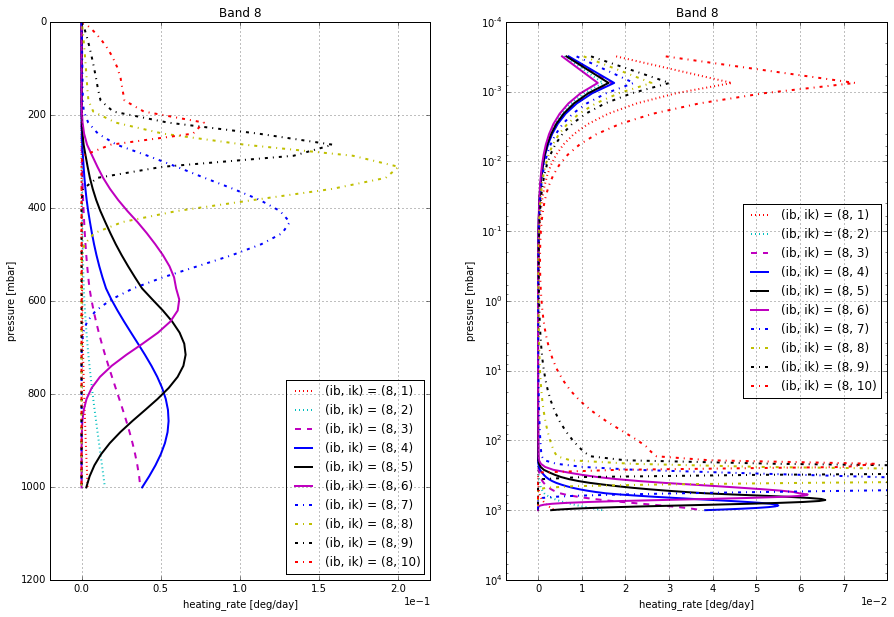

In [25]:
# Heating rate for all g-points.  Band 8

ib = 8
whichrate = 'heating_rate'

fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate = whichrate, ib = ib)

In [26]:
# Total heating rate of Band 8

#fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib = 8)

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')